In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

Number of original training examples: 60000
Number of original test examples: 60000


In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


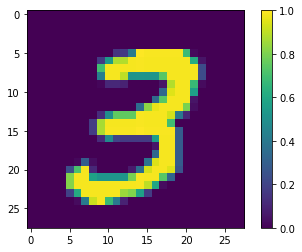

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


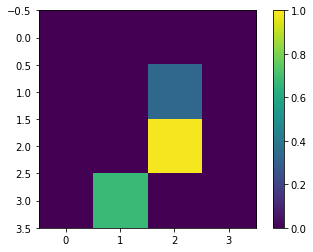

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)
#x_test_nocon, y_test_nocon = remove_contradicting(x_test_small, y_test)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


In [243]:
len(x_test_bin)

1968

In [10]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [11]:
x_train_bin2,y_train_nocon2 = remove_contradicting(x_train_bin, y_train_nocon)
#x_test_bin2,y_test_nocon2 = remove_contradicting(x_test_bin, y_test_nocon)

Number of unique images: 193
Number of 3s:  124
Number of 6s:  113
Number of contradictory images:  44

Initial number of examples:  11520
Remaining non-contradictory examples:  3731


In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    #qubits = cirq.GridQubit.rect(4, 4)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin2]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [240]:
len(x_train_circ)

3731

In [14]:

bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]], dtype=int64)

In [15]:

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [16]:
x_train_bin[0].shape

(4, 4, 1)

In [17]:

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

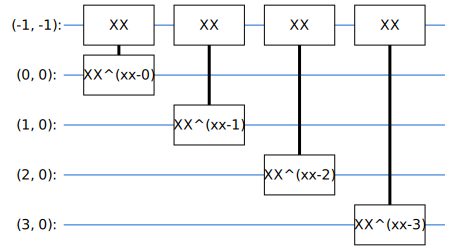

In [18]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [221]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))
    circuit.append(cirq.measure(readout))

    return circuit, cirq.Z(readout)

In [222]:
model_circuit, model_readout = create_quantum_model()

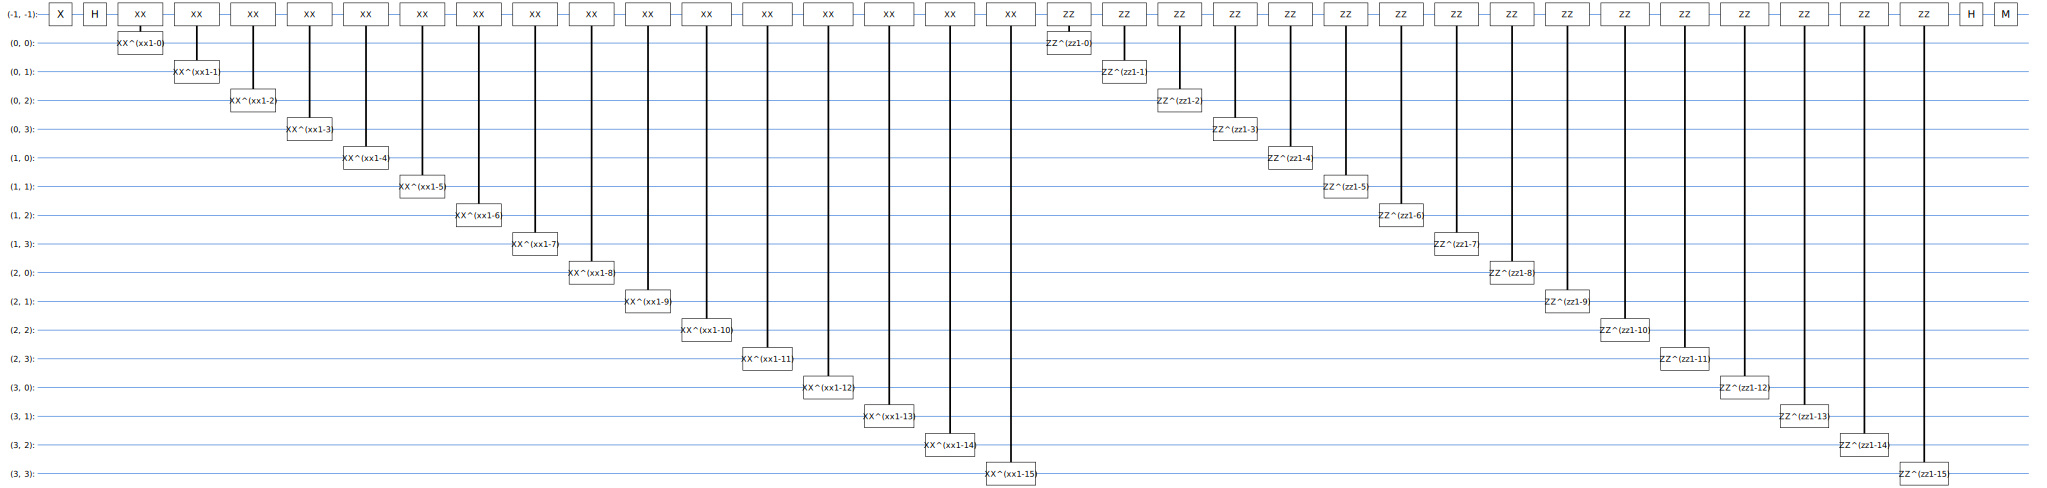

In [223]:
SVGCircuit(model_circuit)

In [224]:

# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
    #tf.keras.layers.Activation('softmax'),
    
])

In [225]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [45]:
y_test

array([False,  True, False, ..., False,  True, False])

In [46]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [226]:

model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    #metrics=['accuracy'])
    metrics=[hinge_accuracy])

#model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

In [229]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_14 (PQC)                 (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [27]:

EPOCHS = 1
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [28]:
len(x_test_tfcirc)

1968

In [29]:
len(x_train_tfcirc_sub)

NameError: name 'x_train_tfcirc_sub' is not defined

In [30]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [31]:
x_train_tfcirc_sub[0].shape

TensorShape([])

In [32]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [239]:

len(x_train_tfcirc)

3731

In [227]:
import time
history = LossHistory()
begin_time = time.time()
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge),
      callbacks=[history])
end_time = time.time()
print('the cost time is '+str(end_time-begin_time))
qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 3731 samples, validate on 1968 samples
3731/3731 [==============================] - 4307s 1s/sample - loss: 1.0003 - hinge_accuracy: 0.4897 - val_loss: 1.0001 - val_hinge_accuracy: 0.3690
the cost time is 4307.249324798584
1968/1968 [==============================] - 35s 18ms/sample - loss: 0.5133 - hinge_accuracy: 0.3690


In [187]:
import time
history = LossHistory()
begin_time = time.time()
qnn_history = model.fit(
      x_train_tfcirc_sub[:200], y_train_hinge_sub[:200],
      batch_size=20,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc[:100], y_test_hinge[:100]),
      callbacks=[history])
end_time = time.time()
print('the cost time is '+str(end_time-begin_time))
#qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 200 samples, validate on 100 samples
200/200 [==============================] - 50s 252ms/sample - loss: 1.0000 - hinge_accuracy: 0.4800 - val_loss: 1.0000 - val_hinge_accuracy: 0.4700
the cost time is 50.57640361785889


In [228]:
qnn_results

[0.513320723200232, 0.36895162]

In [189]:
model.evaluate(x_test_tfcirc, y_test)

1968/1968 [==============================] - 28s 14ms/sample - loss: 0.5132 - hinge_accuracy: 0.5907


[0.5132113821138211, 0.5907258]

In [34]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [152]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [153]:
history = LossHistory()
begin_time = time.time()
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
end_time = time.time()
print('the cost time is '+str(end_time-begin_time))
cnn_results = model.evaluate(x_test, y_test)

Train on 12049 samples, validate on 1968 samples
12049/12049 [==============================] - 31s 3ms/sample - loss: 0.0422 - accuracy: 0.9806 - val_loss: 0.0093 - val_accuracy: 0.9975
the cost time is 31.018183946609497
1968/1968 [==============================] - 2s 787us/sample - loss: 0.0093 - accuracy: 0.9975


In [155]:
len(history.losses)

95

In [38]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/20
11520/11520 - 3s - loss: 0.6808 - accuracy: 0.5030 - val_loss: 0.6717 - val_accuracy: 0.4883
Epoch 2/20
11520/11520 - 0s - loss: 0.6278 - accuracy: 0.5560 - val_loss: 0.6044 - val_accuracy: 0.5462
Epoch 3/20
11520/11520 - 0s - loss: 0.5386 - accuracy: 0.6926 - val_loss: 0.4972 - val_accuracy: 0.7063
Epoch 4/20
11520/11520 - 0s - loss: 0.4419 - accuracy: 0.8135 - val_loss: 0.4123 - val_accuracy: 0.8155
Epoch 5/20
11520/11520 - 0s - loss: 0.3711 - accuracy: 0.8490 - val_loss: 0.3532 - val_accuracy: 0.8166
Epoch 6/20
11520/11520 - 0s - loss: 0.3218 - accuracy: 0.8541 - val_loss: 0.3124 - val_accuracy: 0.8272
Epoch 7/20
11520/11520 - 0s - loss: 0.2878 - accuracy: 0.8754 - val_loss: 0.2846 - val_accuracy: 0.8740
Epoch 8/20
11520/11520 - 0s - loss: 0.2646 - accuracy: 0.8879 - val_loss: 0.2652 - val_accuracy: 0.9121
Epoch 9/20
11520/11520 - 0s - loss: 0.2486 - accuracy: 0.9039 - val_loss: 0.2518 - val_accuracy: 0.9116
Epoch 10/20
115

In [64]:
fair_nn_results[1]

0.91463417

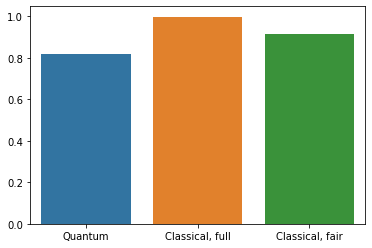

In [40]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])

# QCNN

In [128]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

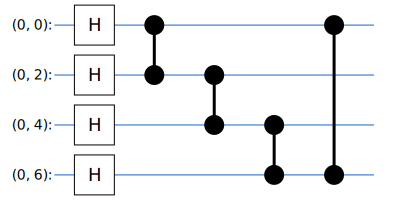

In [129]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 8)[0::2]))

In [130]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[7]]
    circuit += [cirq.YY(*bits)**symbols[8]]
    circuit += [cirq.XX(*bits)**symbols[9]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [139]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

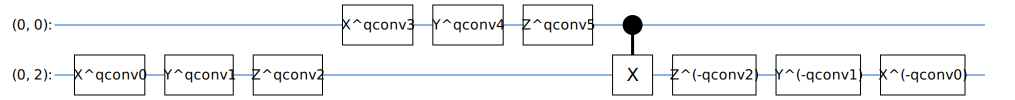

In [131]:
qubits=cirq.GridQubit.rect(1, 8)[0::2][0]
symbols = sympy.symbols('qconv0:63')
xxx=two_qubit_pool(cirq.GridQubit.rect(1, 8)[0::2][0],cirq.GridQubit.rect(1, 8)[0::2][1], symbols[0:12])
SVGCircuit(xxx)

In [140]:

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

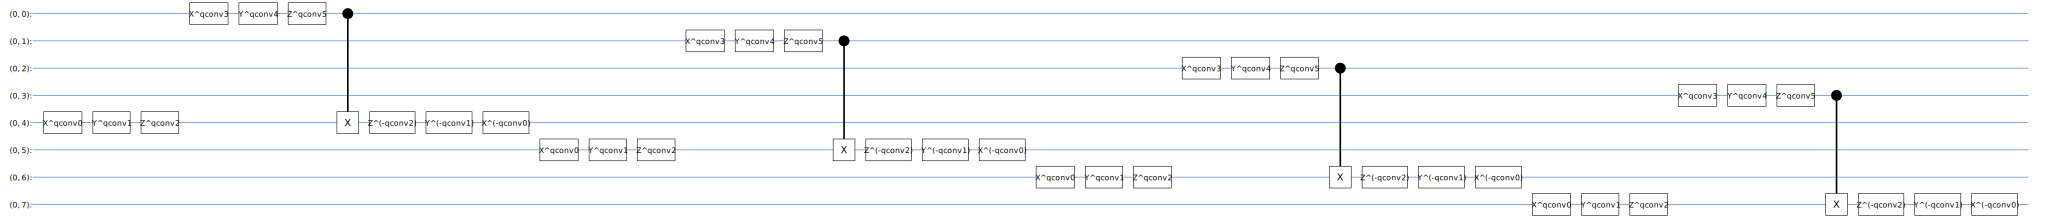

In [141]:
qubits=cirq.GridQubit.rect(1, 8)[0::2][0]
symbols = sympy.symbols('qconv0:63')
xxx=quantum_pool_circuit(cirq.GridQubit.rect(1, 8)[:4],cirq.GridQubit.rect(1, 8)[4:], symbols[0:12])
SVGCircuit(xxx)

TypeError: 'GridQubit' object is not subscriptable

In [142]:
qubits=cirq.GridQubit.rect(1, 8)
symbols = sympy.symbols('qconv0:63')
xxx=quantum_conv_circuit(qubits, symbols[0:15])

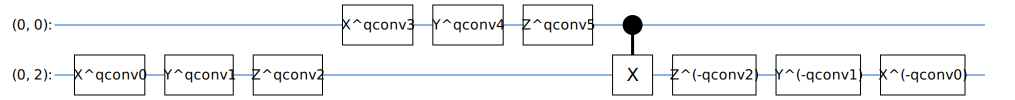

In [134]:
SVGCircuit(xxx)

In [135]:

def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

In [136]:
cirq.GridQubit.rect(1, 8)[0::2][0]

cirq.GridQubit(0, 0)

In [137]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [207]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [236]:
qcnn_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None,)]                 0         
_________________________________________________________________
add_circuit_20 (AddCircuit)  (None,)                   0         
_________________________________________________________________
pqc_13 (PQC)                 (None, 1)                 20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

In [ ]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.Rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [214]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss=tf.losses.mse,
                     metrics=[hinge_accuracy])
begin_time = time.time()
history = qcnn_model.fit(x=x_train_tfcirc_sub,
                                  y=y_train_hinge_sub,
                                  batch_size=32,
                                  epochs=1,
                                  verbose=1,
                                  validation_data=(x_test_tfcirc,
                                                   y_test))
end_time = time.time()
print('the cost time is '+str(end_time-begin_time))
#fair_nn_results = hybrid_model.evaluate(x_test_bin, y_test)

Train on 3731 samples, validate on 1968 samples
3731/3731 [==============================] - 123s 33ms/sample - loss: 1.0019 - hinge_accuracy: 0.4932 - val_loss: 0.5121 - val_hinge_accuracy: 0.6326
the cost time is 122.60638737678528


In [192]:
def accuracy_adjust(value):
    if value> 0.5:
        return value
    else:
        return 1-value

(2, 2): ───X───

(3, 1): ───X───


In [215]:
qcnn_model_results = qcnn_model.evaluate(x_test_tfcirc, y_test)

1968/1968 [==============================] - 6s 3ms/sample - loss: 0.5121 - hinge_accuracy: 0.6326


In [216]:
qcnn_model_results

[0.5121285779689385, 0.6325605]

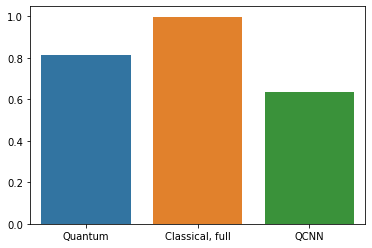

In [231]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
qcnn_accuracy=qcnn_model_results[1]
sns.barplot(["Quantum", "Classical, full",  "QCNN"],
            [qnn_accuracy, cnn_accuracy,qcnn_accuracy])